In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.__version__

'2.1.0'

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6269934715356807887
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5930238567385458838
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1375692488693818721
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 5110237539388793200
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:db:00.0, compute capability: 3.5"
]


---

# Var 0

In [6]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 0

In [7]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [8]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [10]:
from cryoem.distance_estimation import global_standardization

In [11]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [12]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [13]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [3]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [4]:
len(train_idx), len(val_idx), len(test_idx)

(2512, 838, 1650)

---

## Angle Recovery: Estimated Distance FULL

In [15]:
model_filename = f"/mnt/scratch/students/noisy_var{NOISY_VAR}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [16]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [17]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [18]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

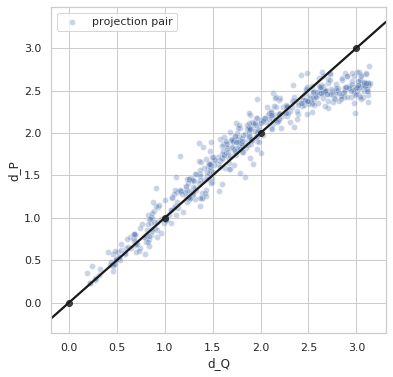

<Figure size 432x288 with 0 Axes>

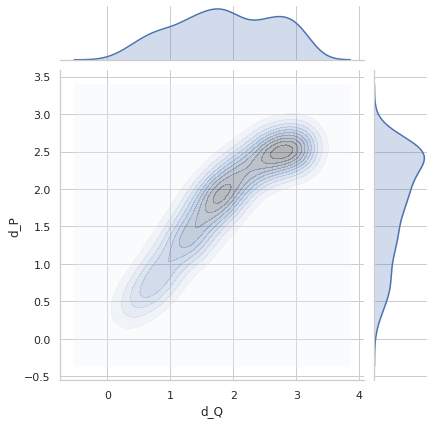

Variance = 0.2368795735909416
Min. angle recovery loss possible = 0.0560023387666876


In [19]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [20]:
from cryoem.angle_recovery import train_angle_recovery

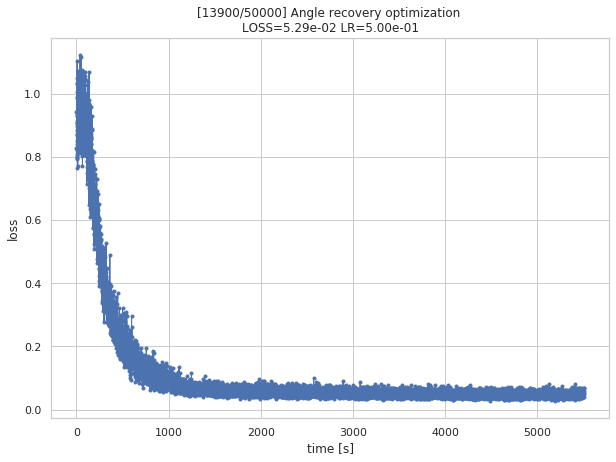

Shape of projections: (1650, 116, 116, 1)step 5000/50000 (1947s): loss = 5.47e-02
step 10000/50000 (3934s): loss = 4.74e-02
step 13900/50000 (5505s): loss = 6.75e-02



In [21]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}")

In [20]:
from cryoem.conversions import quaternion2euler

In [21]:
data = np.load(f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

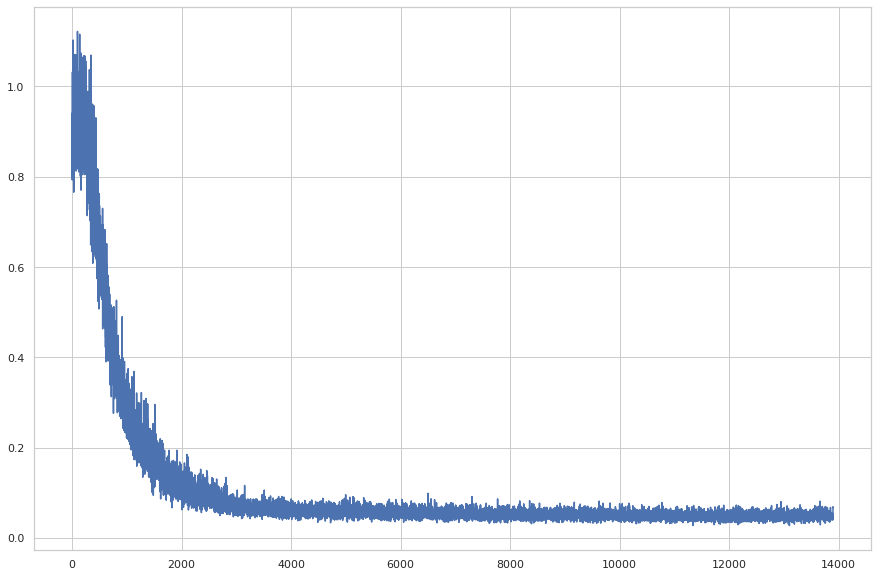

In [24]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-5])
plt.show()

In [25]:
np.mean(losses[losses>1e-6][-10:])

0.0529358354382079

In [36]:
min(losses[losses>1e-6])

0.027398256831719283

In [26]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("/mnt/scratch/students/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [22]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

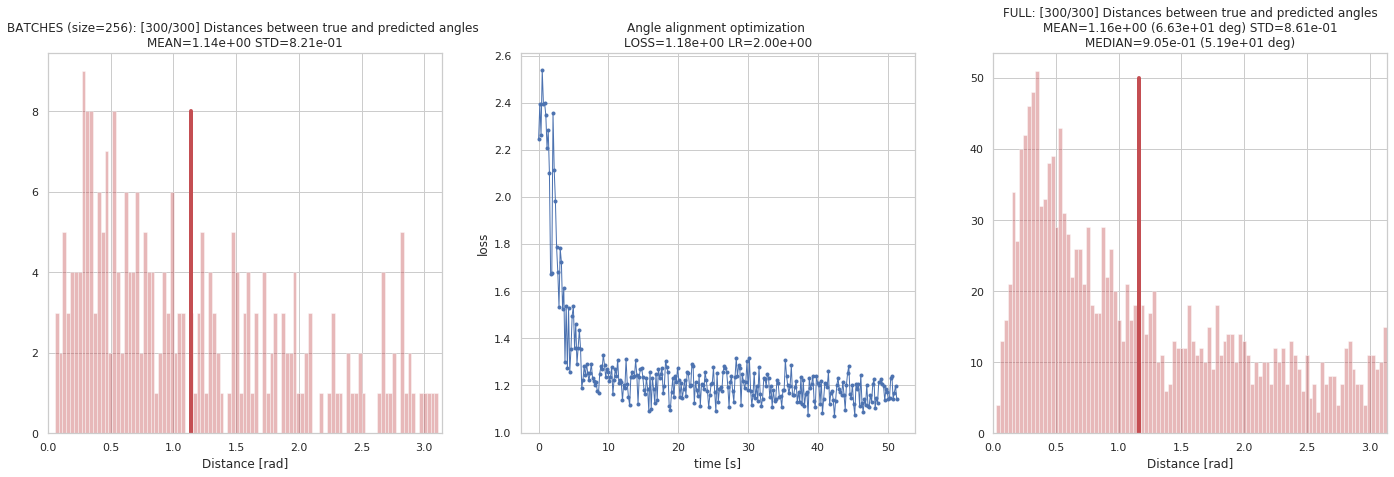

step 30/300 (5s): loss = 1.87e+00
step 60/300 (10s): loss = 1.27e+00
step 90/300 (15s): loss = 1.22e+00
step 120/300 (20s): loss = 1.20e+00
step 150/300 (27s): loss = 1.20e+00
step 180/300 (32s): loss = 1.22e+00
step 210/300 (37s): loss = 1.19e+00
step 240/300 (42s): loss = 1.17e+00
step 270/300 (47s): loss = 1.17e+00
step 300/300 (52s): loss = 1.17e+00



In [23]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true[test_idx], 
                                                        angles_predicted=angles_predicted)

In [25]:
m = m
trajectory_first = trajectory[0]
loss_first = losses[0]
trajectory_last = trajectory[-1]
loss_last = losses[-1]

In [26]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, 1.0],
 array([2.23965425, 0.79797537, 2.37692442, 5.76478748, 5.52553584,
        3.3255753 ]),
 2.6429688560684164,
 array([-57.84894053,  31.18388646,  21.73784548,  15.05629936,
          3.20500678,  10.60400614]),
 1.0547059818920415)

In [27]:
losses[-1], m, a_R

(1.0547059818920415,
 [1.0, 1.0, 1.0, 1.0],
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([-57.84894053,  31.18388646,  21.73784548,  15.05629936,
           3.20500678,  10.60400614])>])

In [30]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [31]:
# from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [32]:
# plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [33]:
# ipv.screenshot()

In [34]:
# plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [35]:
# ipv.screenshot()

---

# Var 5

In [46]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 5

In [7]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [8]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [10]:
from cryoem.distance_estimation import global_standardization

In [11]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [12]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [13]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [14]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

---

## Angle Recovery: Estimated Distance FULL

In [15]:
model_filename = f"/mnt/scratch/students/noisy_var{NOISY_VAR}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [16]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [17]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [18]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

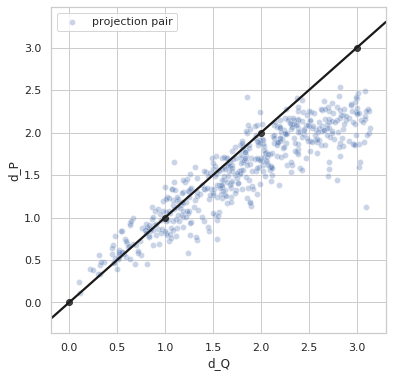

<Figure size 432x288 with 0 Axes>

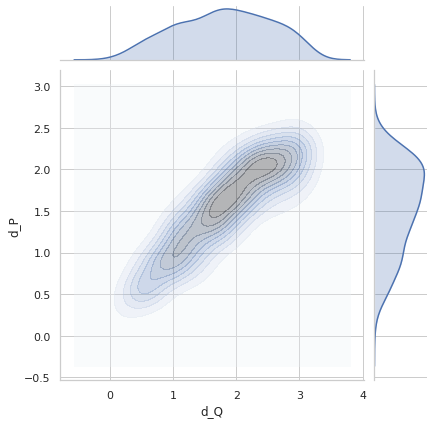

Variance = 0.44511955960220856
Min. angle recovery loss possible = 0.19774444690620538


In [19]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [20]:
from cryoem.angle_recovery import train_angle_recovery

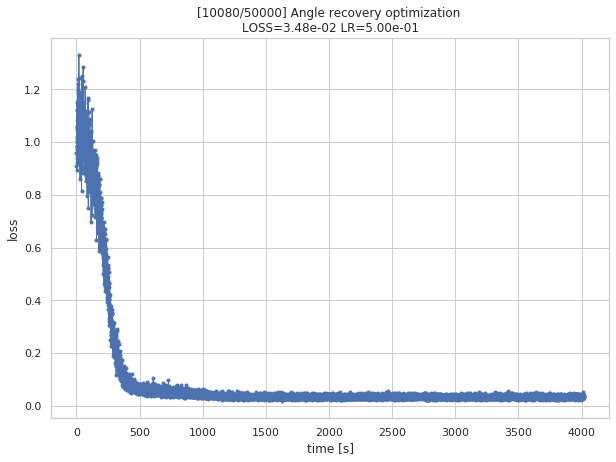

Shape of projections: (1650, 116, 116, 1)step 5000/50000 (1978s): loss = 3.73e-02
step 10000/50000 (3985s): loss = 3.99e-02
step 10080/50000 (4018s): loss = 3.41e-02



In [21]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}")

In [41]:
from cryoem.conversions import quaternion2euler

In [47]:
data = np.load(f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

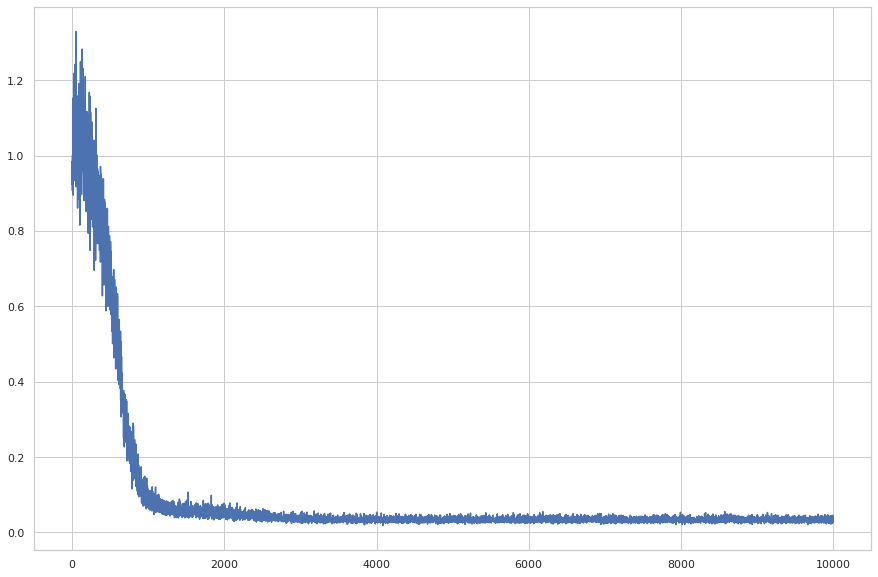

In [51]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[:10000])
plt.show()

In [52]:
min(losses[:10000])

0.017951076275801878

In [26]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("/mnt/scratch/students/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [27]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [28]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=angles_true[test_idx], 
#                                                         angles_predicted=angles_predicted)

In [29]:
# losses[-1], m, a_R

In [30]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [31]:
# from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [32]:
# plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [33]:
# ipv.screenshot()

In [34]:
# plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [35]:
# ipv.screenshot()

---

# Var 10

In [36]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 10

In [37]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [38]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [39]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [40]:
from cryoem.distance_estimation import global_standardization

In [41]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [42]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [43]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [44]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

---

## Angle Recovery: Estimated Distance FULL

In [45]:
model_filename = f"/mnt/scratch/students/noisy_var{NOISY_VAR}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [46]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [47]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [48]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

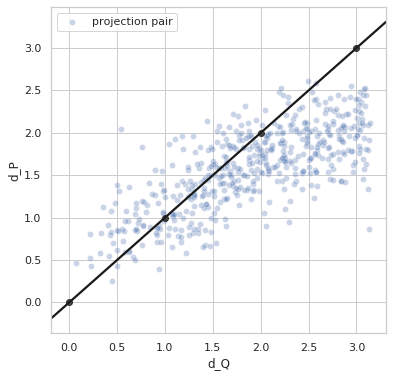

<Figure size 432x288 with 0 Axes>

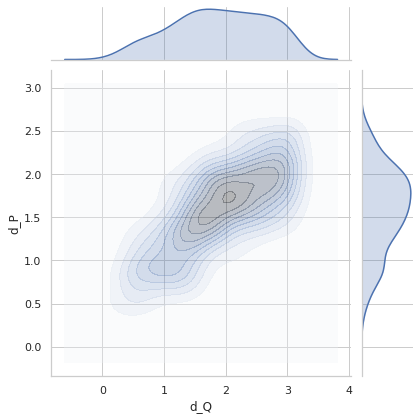

Variance = 0.6003109329335045
Min. angle recovery loss possible = 0.35966936226160484


In [49]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [50]:
from cryoem.angle_recovery import train_angle_recovery

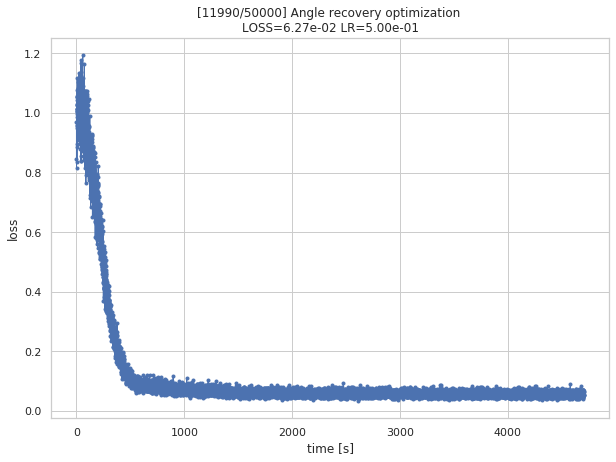

Shape of projections: (1650, 116, 116, 1)step 5000/50000 (1934s): loss = 4.77e-02
step 10000/50000 (3895s): loss = 5.46e-02
step 11990/50000 (4703s): loss = 5.53e-02



In [51]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}")

In [52]:
from cryoem.conversions import quaternion2euler

In [53]:
data = np.load(f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

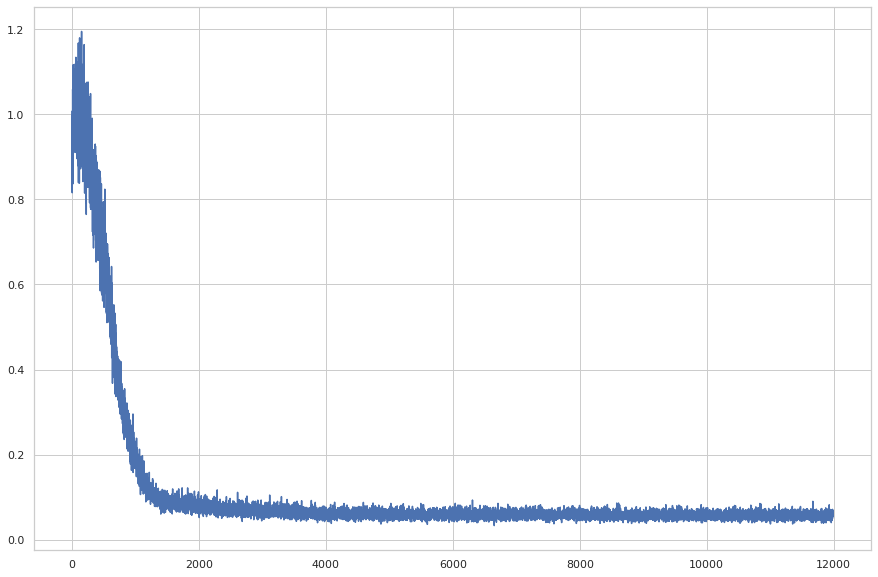

In [54]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-5])
plt.show()

In [55]:
np.mean(losses[losses>1e-6][-10:])

0.06274963715908058

In [56]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("/mnt/scratch/students/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [57]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [58]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=angles_true[test_idx], 
#                                                         angles_predicted=angles_predicted)

In [59]:
# losses[-1], m, a_R

In [60]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [61]:
# from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [62]:
# plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [63]:
# ipv.screenshot()

In [64]:
# plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [65]:
# ipv.screenshot()

# Var 20

In [66]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 20

In [67]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [68]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [69]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [70]:
from cryoem.distance_estimation import global_standardization

In [71]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [72]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [73]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [74]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

---

## Angle Recovery: Estimated Distance FULL

In [75]:
model_filename = f"/mnt/scratch/students/noisy_var{NOISY_VAR}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [76]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [77]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [78]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

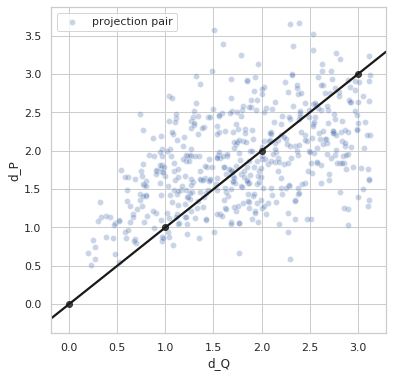

<Figure size 432x288 with 0 Axes>

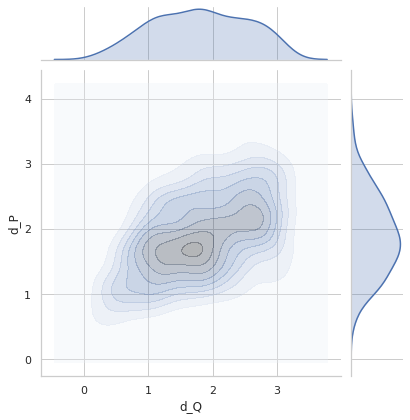

Variance = 0.689735389979667
Min. angle recovery loss possible = 0.4748057384478439


In [79]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [80]:
from cryoem.angle_recovery import train_angle_recovery

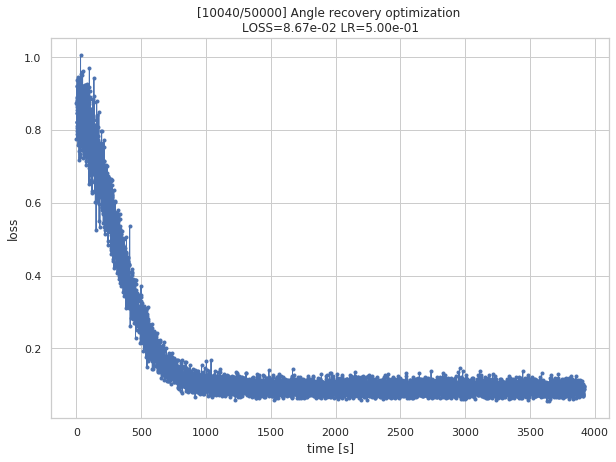

Shape of projections: (1650, 116, 116, 1)step 5000/50000 (1939s): loss = 1.12e-01
step 10000/50000 (3899s): loss = 9.94e-02
step 10040/50000 (3915s): loss = 8.72e-02



In [81]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}")

In [82]:
from cryoem.conversions import quaternion2euler

In [83]:
data = np.load(f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


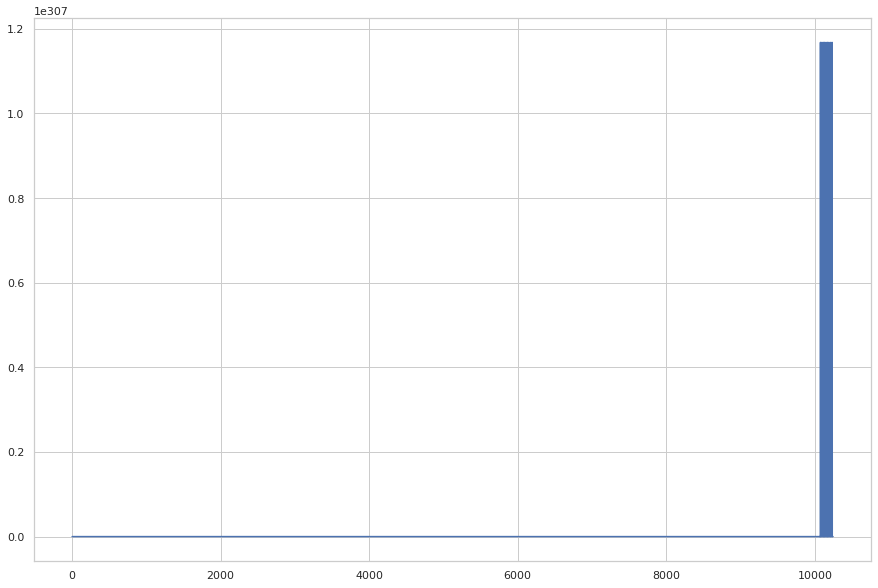

In [84]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-5])
plt.show()

In [85]:
np.mean(losses[losses>1e-6][-10:])

/home/jbanjac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


3.3718841520668828e+245

In [86]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("/mnt/scratch/students/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [87]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [88]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=angles_true[test_idx], 
#                                                         angles_predicted=angles_predicted)

In [89]:
# losses[-1], m, a_R

In [90]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [91]:
# from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [92]:
# plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [93]:
# ipv.screenshot()

In [94]:
# plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [95]:
# ipv.screenshot()

# Var 25

In [96]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 25

In [97]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [98]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [99]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [100]:
from cryoem.distance_estimation import global_standardization

In [101]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [102]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [103]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [104]:
data = np.load(f"data/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

---

## Angle Recovery: Estimated Distance FULL

In [105]:
model_filename = f"/mnt/scratch/students/noisy_var{NOISY_VAR}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [106]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [107]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [108]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

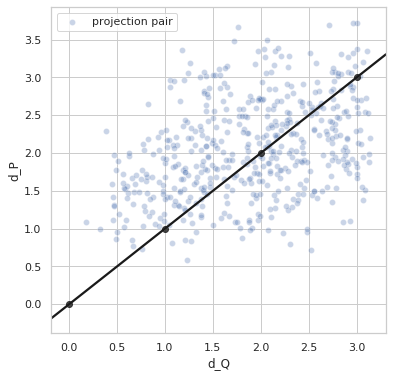

<Figure size 432x288 with 0 Axes>

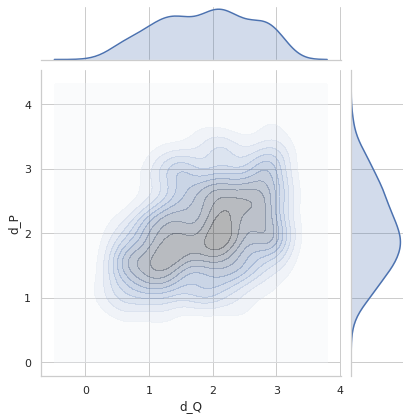

Variance = 0.7838599076699111
Min. angle recovery loss possible = 0.6132362838467107


In [109]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [110]:
from cryoem.angle_recovery import train_angle_recovery

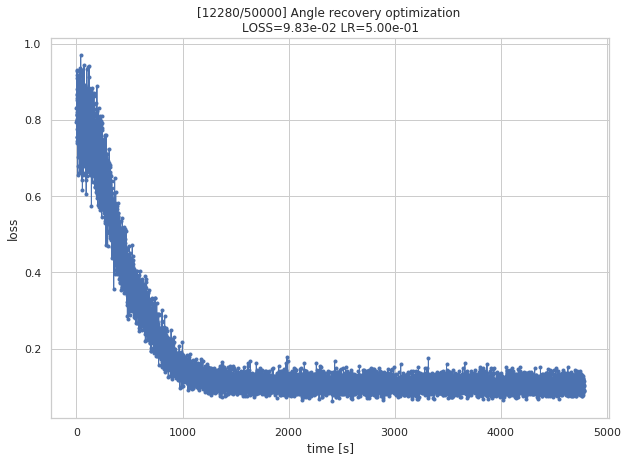

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}")

In [ ]:
from cryoem.conversions import quaternion2euler

In [ ]:
data = np.load(f"/mnt/scratch/students/angle_recovery_limited3.14_estimated_noisy{NOISY_VAR}.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [ ]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[losses>1e-5])
plt.show()

In [ ]:
np.mean(losses[losses>1e-6][-10:])

In [ ]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("/mnt/scratch/students/angles_predicted_limited3.14_estimated_50k_testset", angles_predicted)

### Angle Alignment

In [ ]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [ ]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=angles_true[test_idx], 
#                                                         angles_predicted=angles_predicted)

In [ ]:
# losses[-1], m, a_R

In [ ]:
# q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

# angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

# np.save("data/5j0n/angles_predicted_rotated_limited3.14_estimated_50k_testset", angles_predicted_rotated)

In [ ]:
# from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [ ]:
# plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [ ]:
# ipv.screenshot()

In [ ]:
# plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)

In [ ]:
# ipv.screenshot()